In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)

trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, not_nn_loss_weight=50)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 0.8734 | val loss 0.8765 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 24.37s
train epoch 01/15 | batch 2001/2000 | loss 0.6796 | val loss 0.5585 | acc 0.8176 | f1 0.2540 | prec 0.9881 | recall 0.1457 | roc auc 0.5839 | pr auc 0.4075 | elapsed 72.97s
train epoch 02/15 | batch 2001/2000 | loss 0.4910 | val loss 0.4396 | acc 0.8336 | f1 0.4107 | prec 0.8368 | recall 0.2721 | roc auc 0.7663 | pr auc 0.5924 | elapsed 72.76s
train epoch 03/15 | batch 2001/2000 | loss 0.3802 | val loss 0.3677 | acc 0.8577 | f1 0.5657 | prec 0.8091 | recall 0.4349 | roc auc 0.8410 | pr auc 0.7098 | elapsed 73.81s
train epoch 04/15 | batch 2001/2000 | loss 0.2980 | val loss 0.3123 | acc 0.8882 | f1 0.6837 | prec 0.8617 | recall 0.5666 | roc auc 0.8796 | pr auc 0.7910 | elapsed 73.47s
train epoch 05/15 | batch 2001/2000 | loss 0.2389 |

In [4]:
input = T.rand(10)
print(input)
output = trained_reasoner.not_nn(trained_reasoner.not_nn(input))
print(output)

tensor([0.7046, 0.9691, 0.6363, 0.5471, 0.4491, 0.2415, 0.8017, 0.2631, 0.6155,
        0.7288])
tensor([0.7137, 0.9567, 0.3808, 0.4443, 0.4151, 0.0026, 0.8280, 0.3523, 0.8567,
        0.5887], grad_fn=<SqueezeBackward3>)


In [5]:
trained_reasoner.not_nn.weight

Parameter containing:
tensor([[-0.5135,  0.1917,  0.4639, -0.1053,  0.1076, -0.2062,  0.3021,  0.4193,
          0.2023,  0.1297],
        [ 0.2320, -0.3860,  0.1063,  0.1058,  0.3602,  0.4370,  0.4112,  0.1467,
          0.4040, -0.2759],
        [ 0.5504,  0.0827,  0.4219,  0.2661,  0.0175, -0.1946, -0.2945,  0.1460,
          0.0245, -0.0516],
        [-0.0619,  0.0831,  0.3392, -0.4392,  0.3252, -0.1669,  0.0807, -0.5007,
         -0.1679, -0.4350],
        [ 0.0668,  0.3530, -0.0146,  0.3351, -0.1432, -0.1269,  0.4821, -0.5121,
          0.3636,  0.4014],
        [-0.3018,  0.5498, -0.2413, -0.1231, -0.0875,  0.5732, -0.1327,  0.1221,
          0.0397,  0.0403],
        [ 0.2495,  0.3769, -0.2964,  0.1421,  0.4367, -0.0732,  0.4058,  0.3008,
         -0.4051, -0.0522],
        [ 0.5496,  0.0933,  0.2363, -0.5971, -0.5490,  0.0873,  0.2976,  0.1564,
         -0.0241, -0.0287],
        [ 0.2334,  0.4986,  0.0596, -0.2113,  0.3718,  0.0726, -0.5218, -0.0290,
          0.4106, -0.0479

In [8]:
print(T.round(T.matmul( trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100)

tensor([[ 1.0000,  0.0100,  0.0100,  0.0000,  0.0000,  0.0100,  0.0000,  0.0000,
         -0.0100, -0.0000],
        [-0.0000,  1.0100, -0.0200, -0.0200,  0.0100, -0.0200, -0.0000,  0.0100,
          0.0100, -0.0100],
        [ 0.0200, -0.0400,  0.7000, -0.1400, -0.0200, -0.2800,  0.0400,  0.0700,
          0.2300, -0.1200],
        [ 0.0200, -0.0300, -0.1300,  0.9500, -0.0100, -0.1200,  0.0200,  0.0300,
          0.1100, -0.0500],
        [-0.0100,  0.0100, -0.0400, -0.0200,  1.0100, -0.0400,  0.0000,  0.0100,
          0.0300, -0.0200],
        [ 0.0200, -0.0400, -0.2900, -0.1400, -0.0200,  0.7300,  0.0400,  0.0700,
          0.2400, -0.1000],
        [ 0.0100, -0.0100,  0.0200,  0.0100, -0.0000,  0.0200,  1.0100, -0.0000,
         -0.0100,  0.0000],
        [-0.0000,  0.0100,  0.1000,  0.0500,  0.0000,  0.0900, -0.0100,  0.9800,
         -0.0800,  0.0400],
        [-0.0100,  0.0300,  0.2700,  0.1300,  0.0100,  0.2600, -0.0200, -0.0700,
          0.8000,  0.1100],
        [ 0.0100, -

In [10]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, not_nn_loss_weight=0.1)
    else:
        train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.1985 | val loss 1.1985 | acc 0.6322 | f1 0.3945 | prec 0.3072 | recall 0.5512 | roc auc 0.6494 | pr auc 0.4873 | elapsed 18.79s
train epoch 01/10 | batch 1251/1250 | loss 0.9996 | val loss 0.7772 | acc 0.7280 | f1 0.4779 | prec 0.4101 | recall 0.5726 | roc auc 0.7348 | pr auc 0.5658 | elapsed 35.39s
train epoch 02/10 | batch 1251/1250 | loss 0.6536 | val loss 0.5084 | acc 0.8079 | f1 0.5819 | prec 0.5524 | recall 0.6147 | roc auc 0.8184 | pr auc 0.6719 | elapsed 38.87s
train epoch 03/10 | batch 1251/1250 | loss 0.4417 | val loss 0.3530 | acc 0.8663 | f1 0.6866 | prec 0.7003 | recall 0.6735 | roc auc 0.8826 | pr auc 0.7754 | elapsed 36.55s
train epoch 04/10 | batch 1251/1250 | loss 0.3197 | val loss 0.2644 | acc 0.9026 | f1 0.7644 | prec 0.8059 | recall 0.7269 | roc auc 0.9233 | pr auc 0.8496 | elapsed 35.85s
train epoch 05/10 | batch 1251/1250 | loss 0.2485 | val loss 0.2114 | acc 0.9245 | f1 0.8149 | prec 0.8729 | recall 0.

In [11]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240625T171914


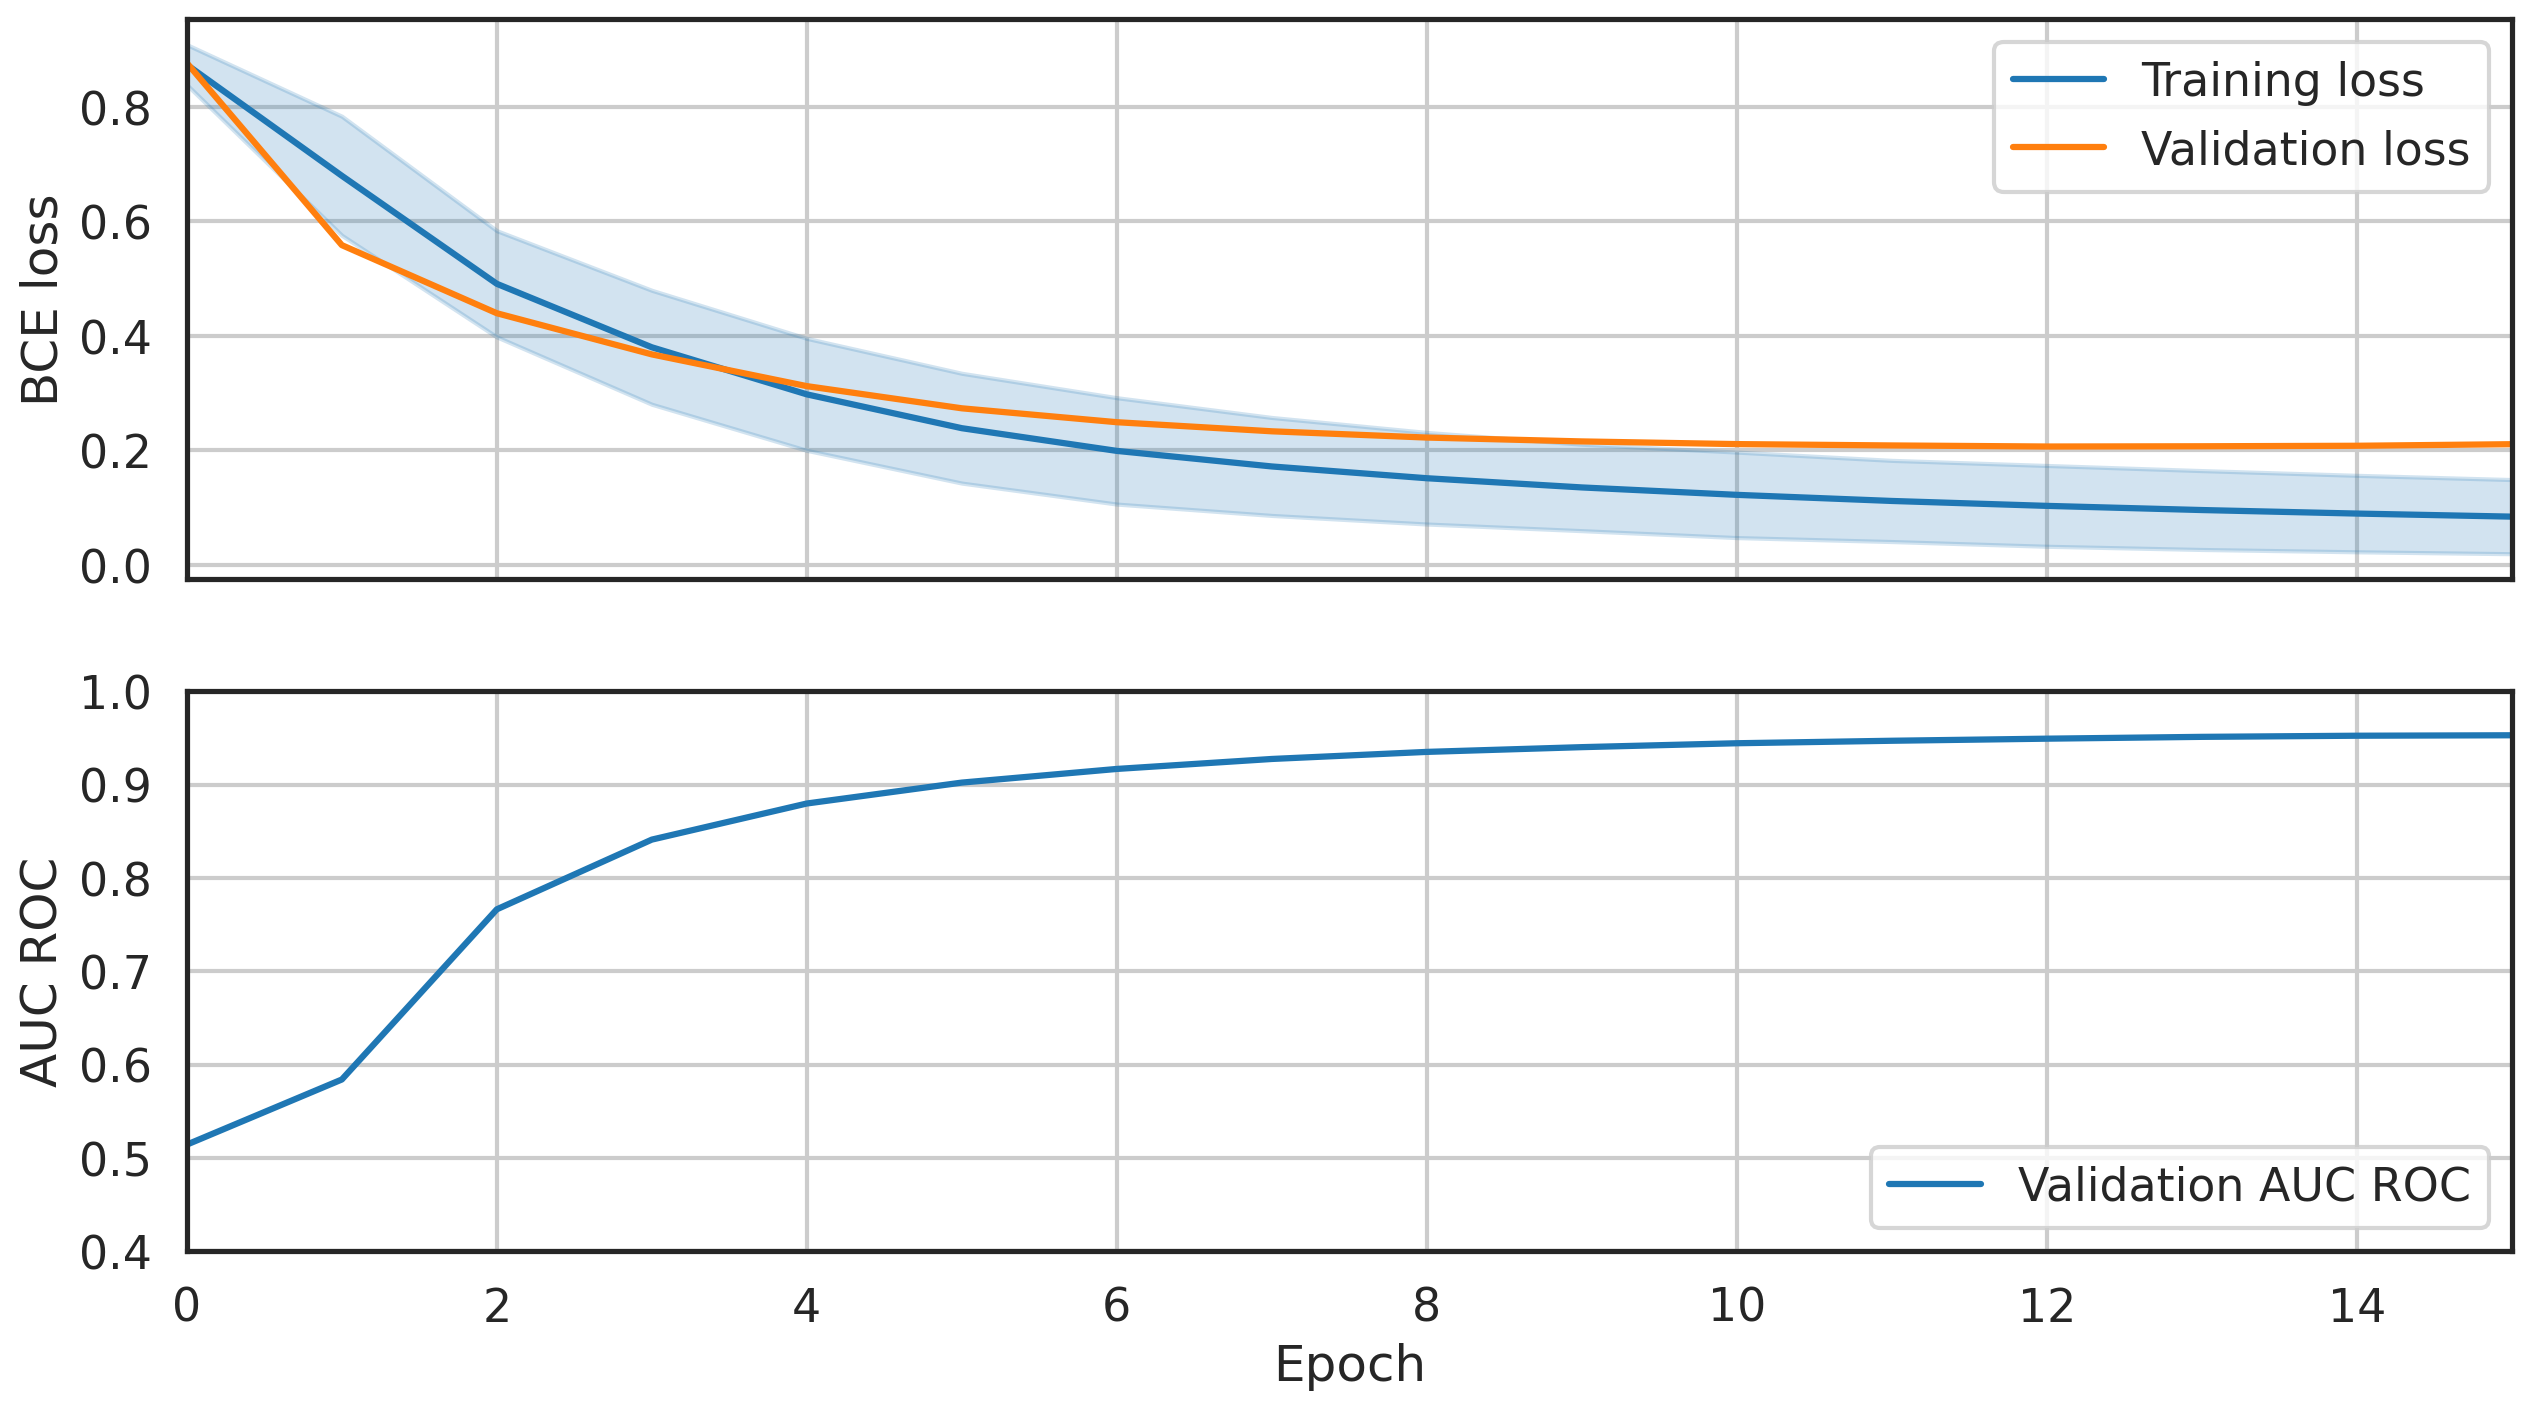

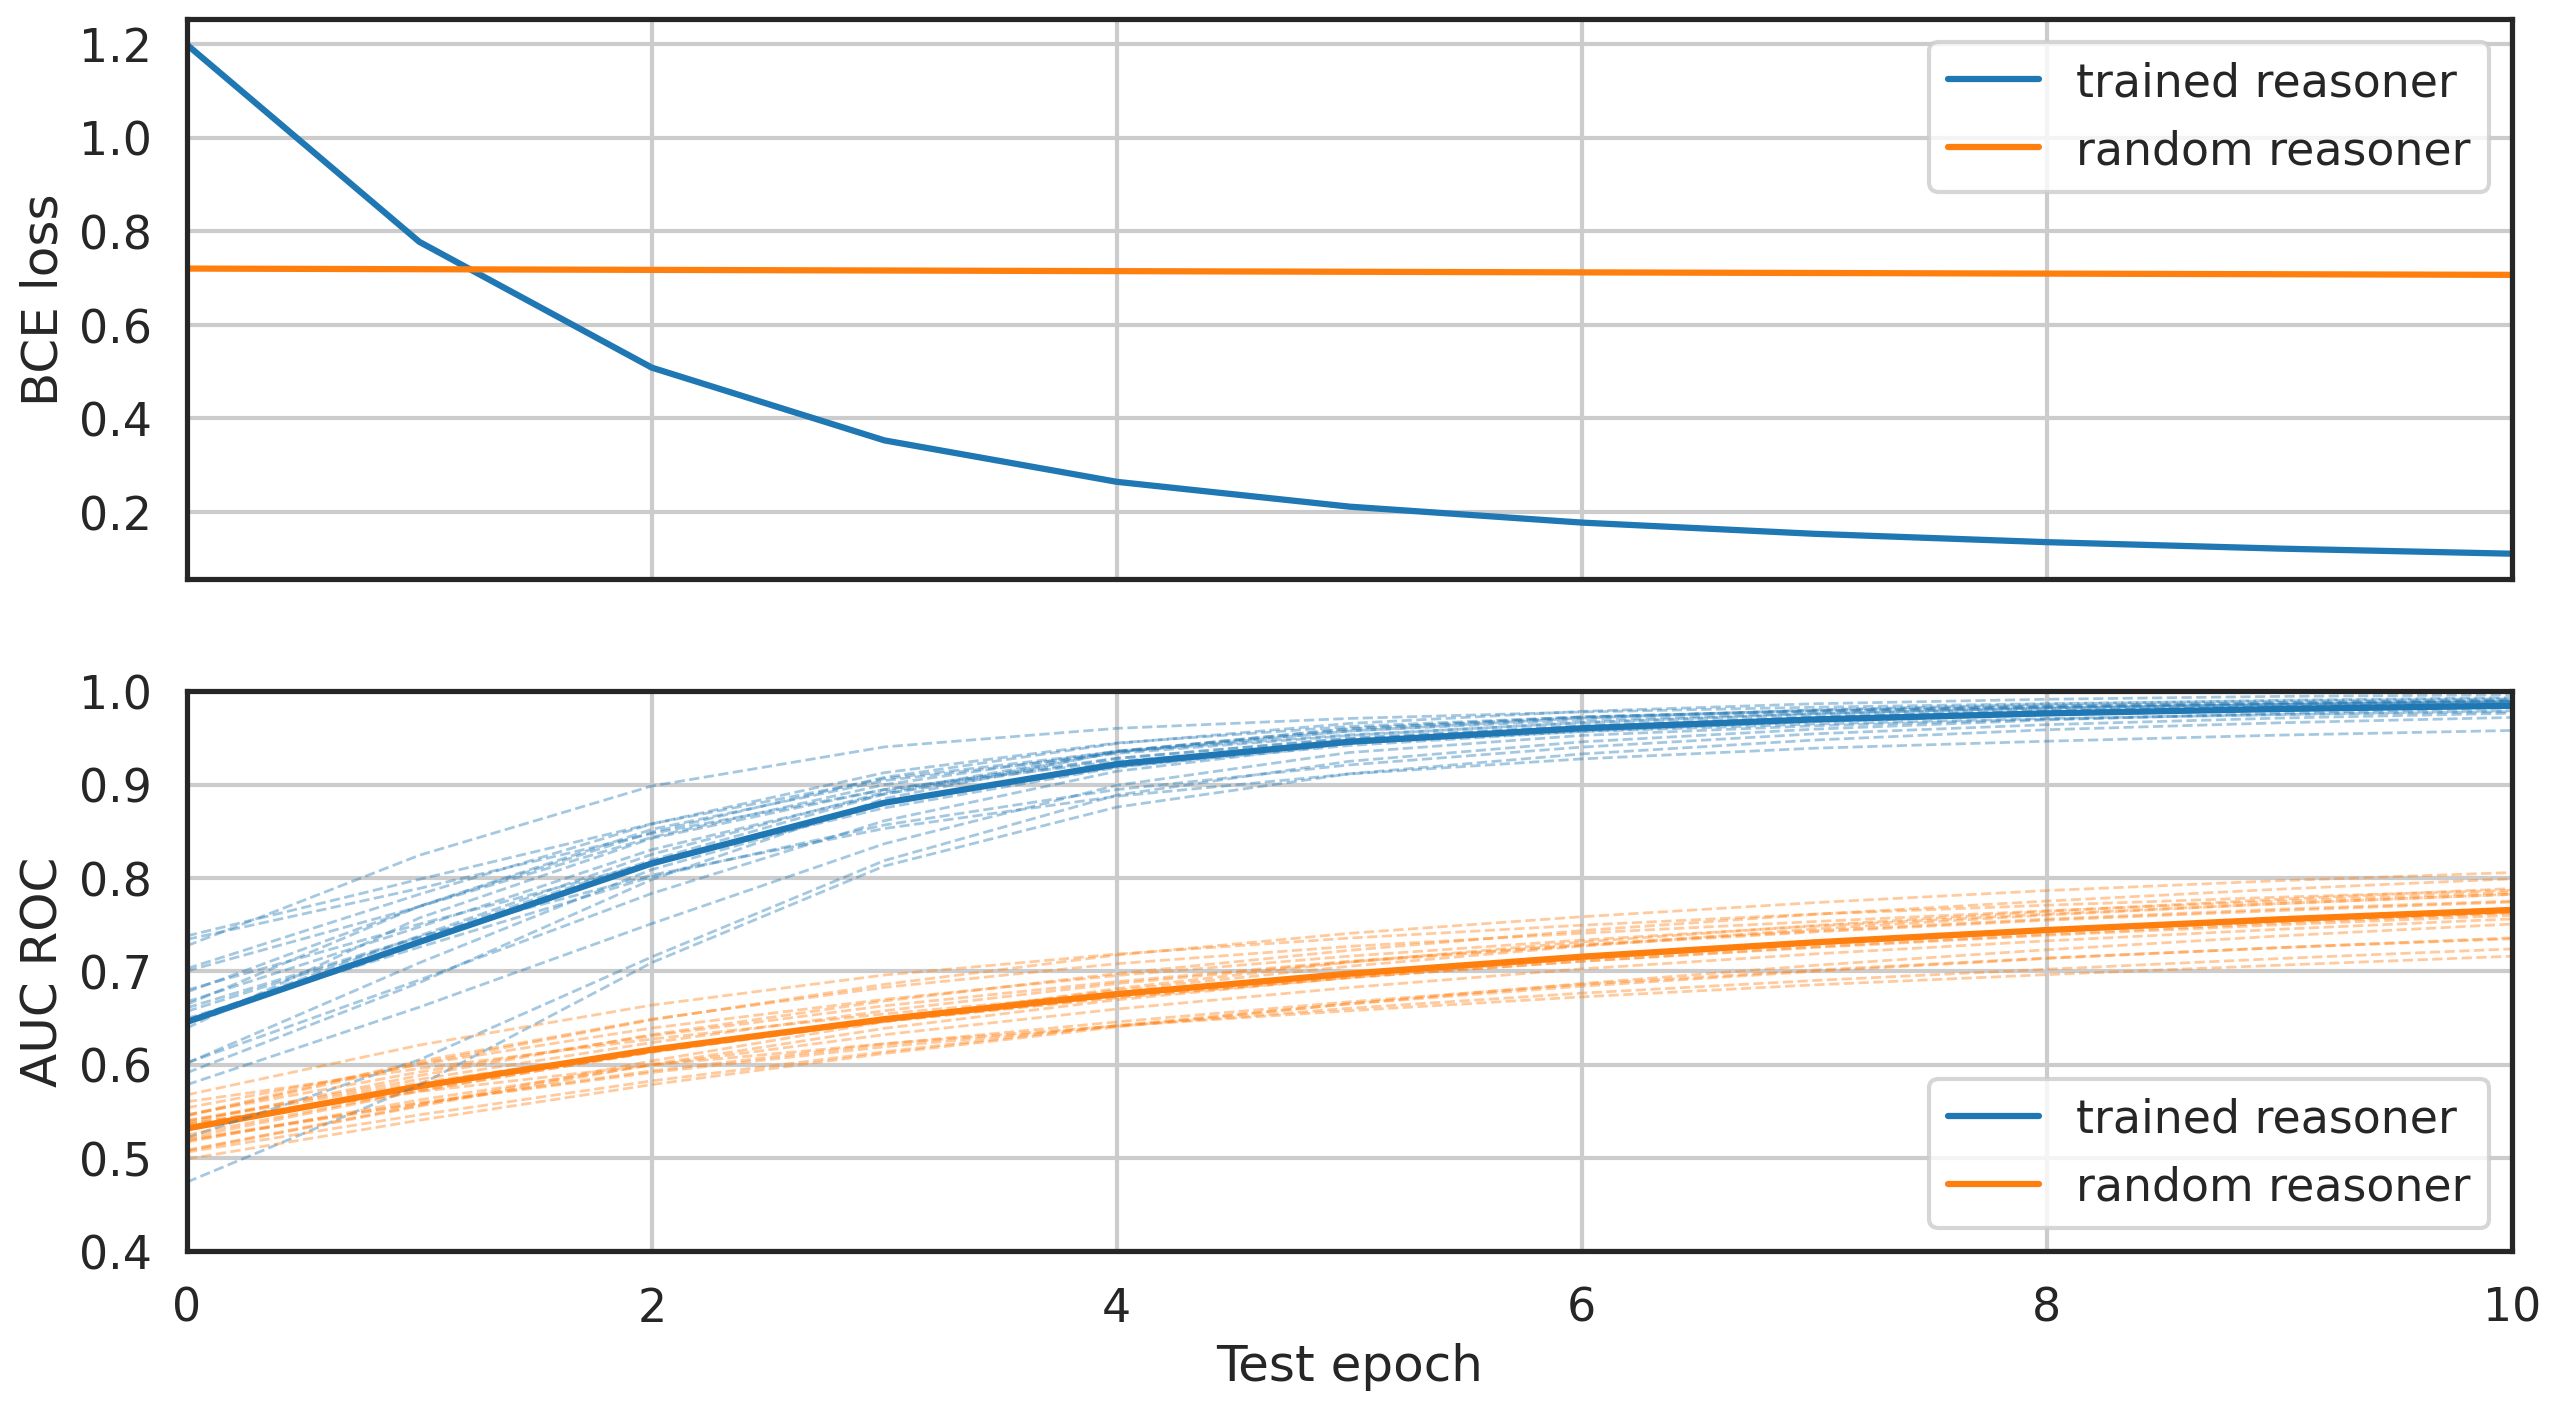

             mean       std     micro
acc      0.961300  0.015202  0.961300
prec     0.961155  0.027722  0.961161
recall   0.854824  0.047499  0.856601
f1       0.904543  0.036851  0.905874
auc_roc  0.984358  0.008664  0.985378
auc_pr   0.964352  0.018284  0.966799
             mean       std     micro
acc      0.287375  0.027590  0.287375
prec     0.231894  0.030550  0.232159
recall   0.987012  0.012017  0.987236
f1       0.374628  0.039972  0.375917
auc_roc  0.765613  0.024266  0.766383
auc_pr   0.558881  0.052247  0.563443


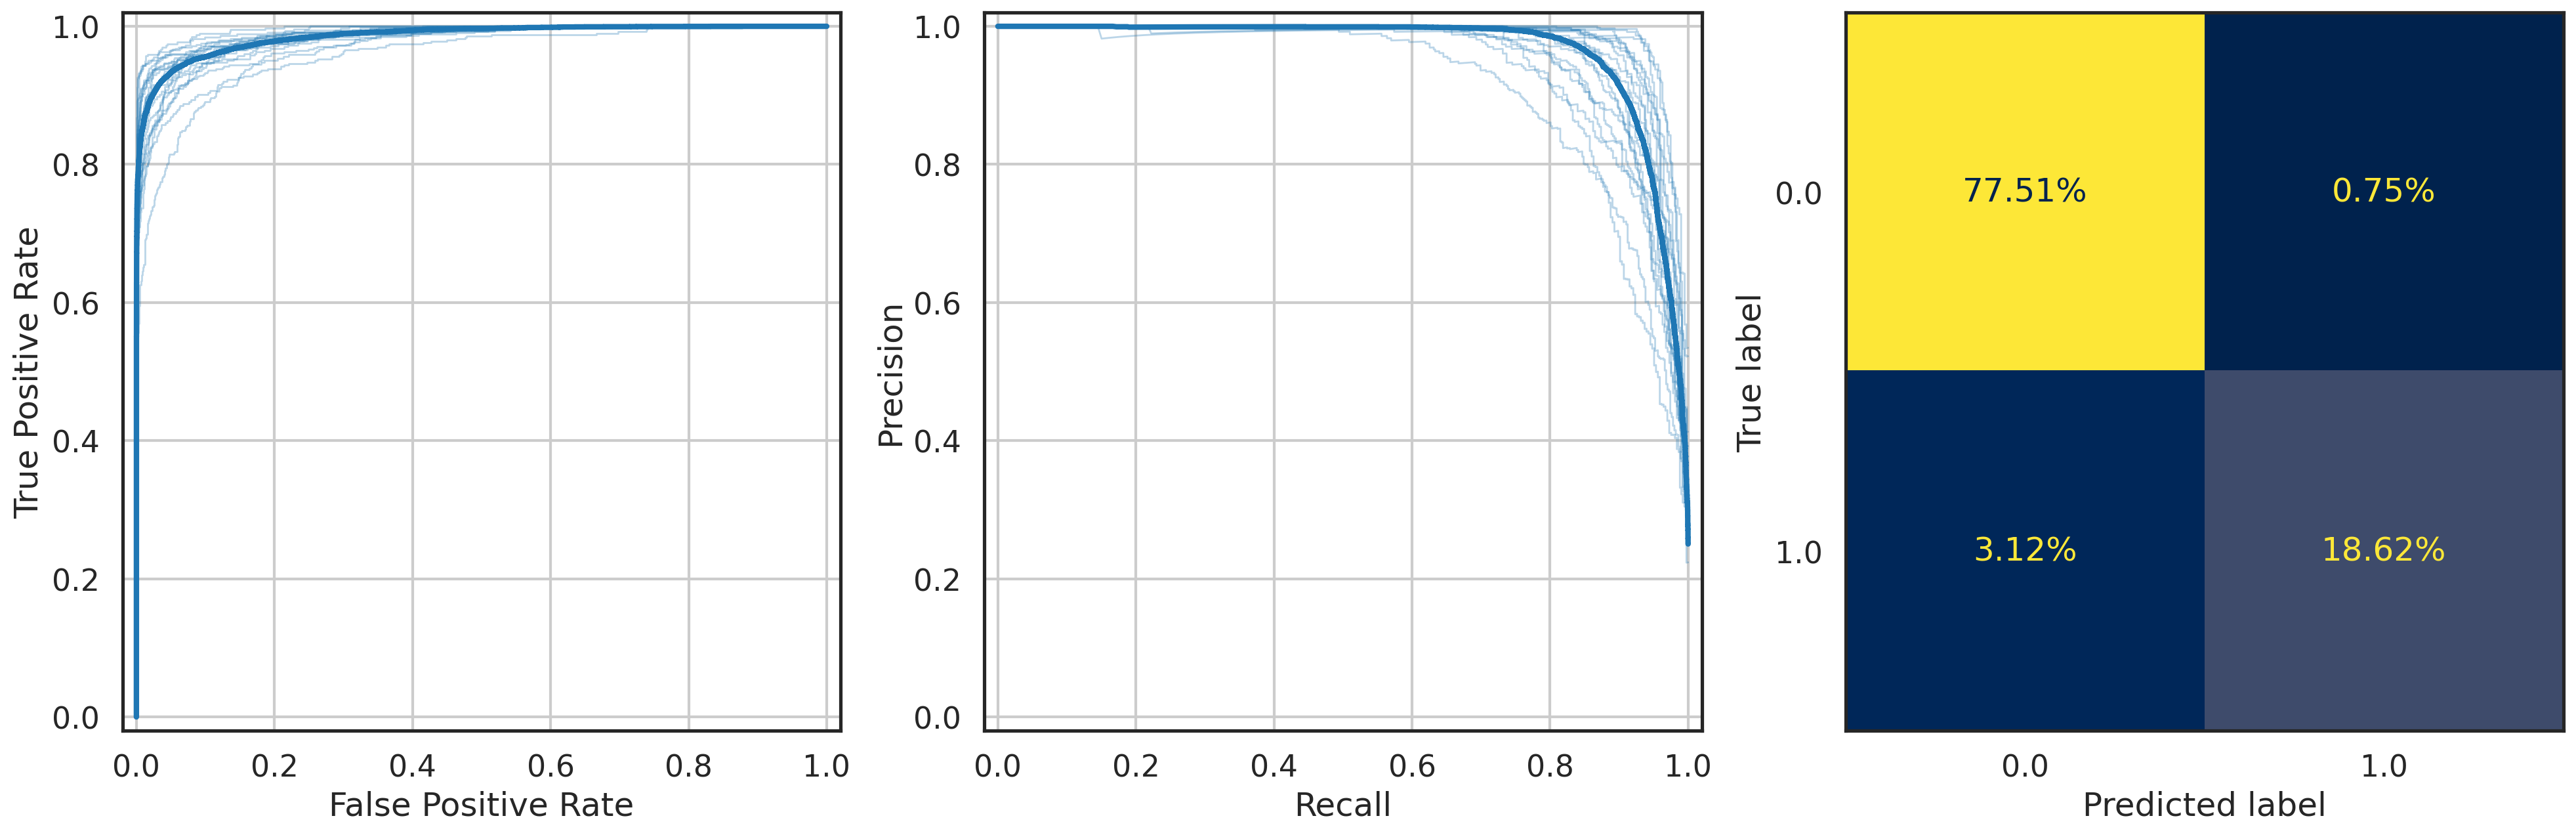

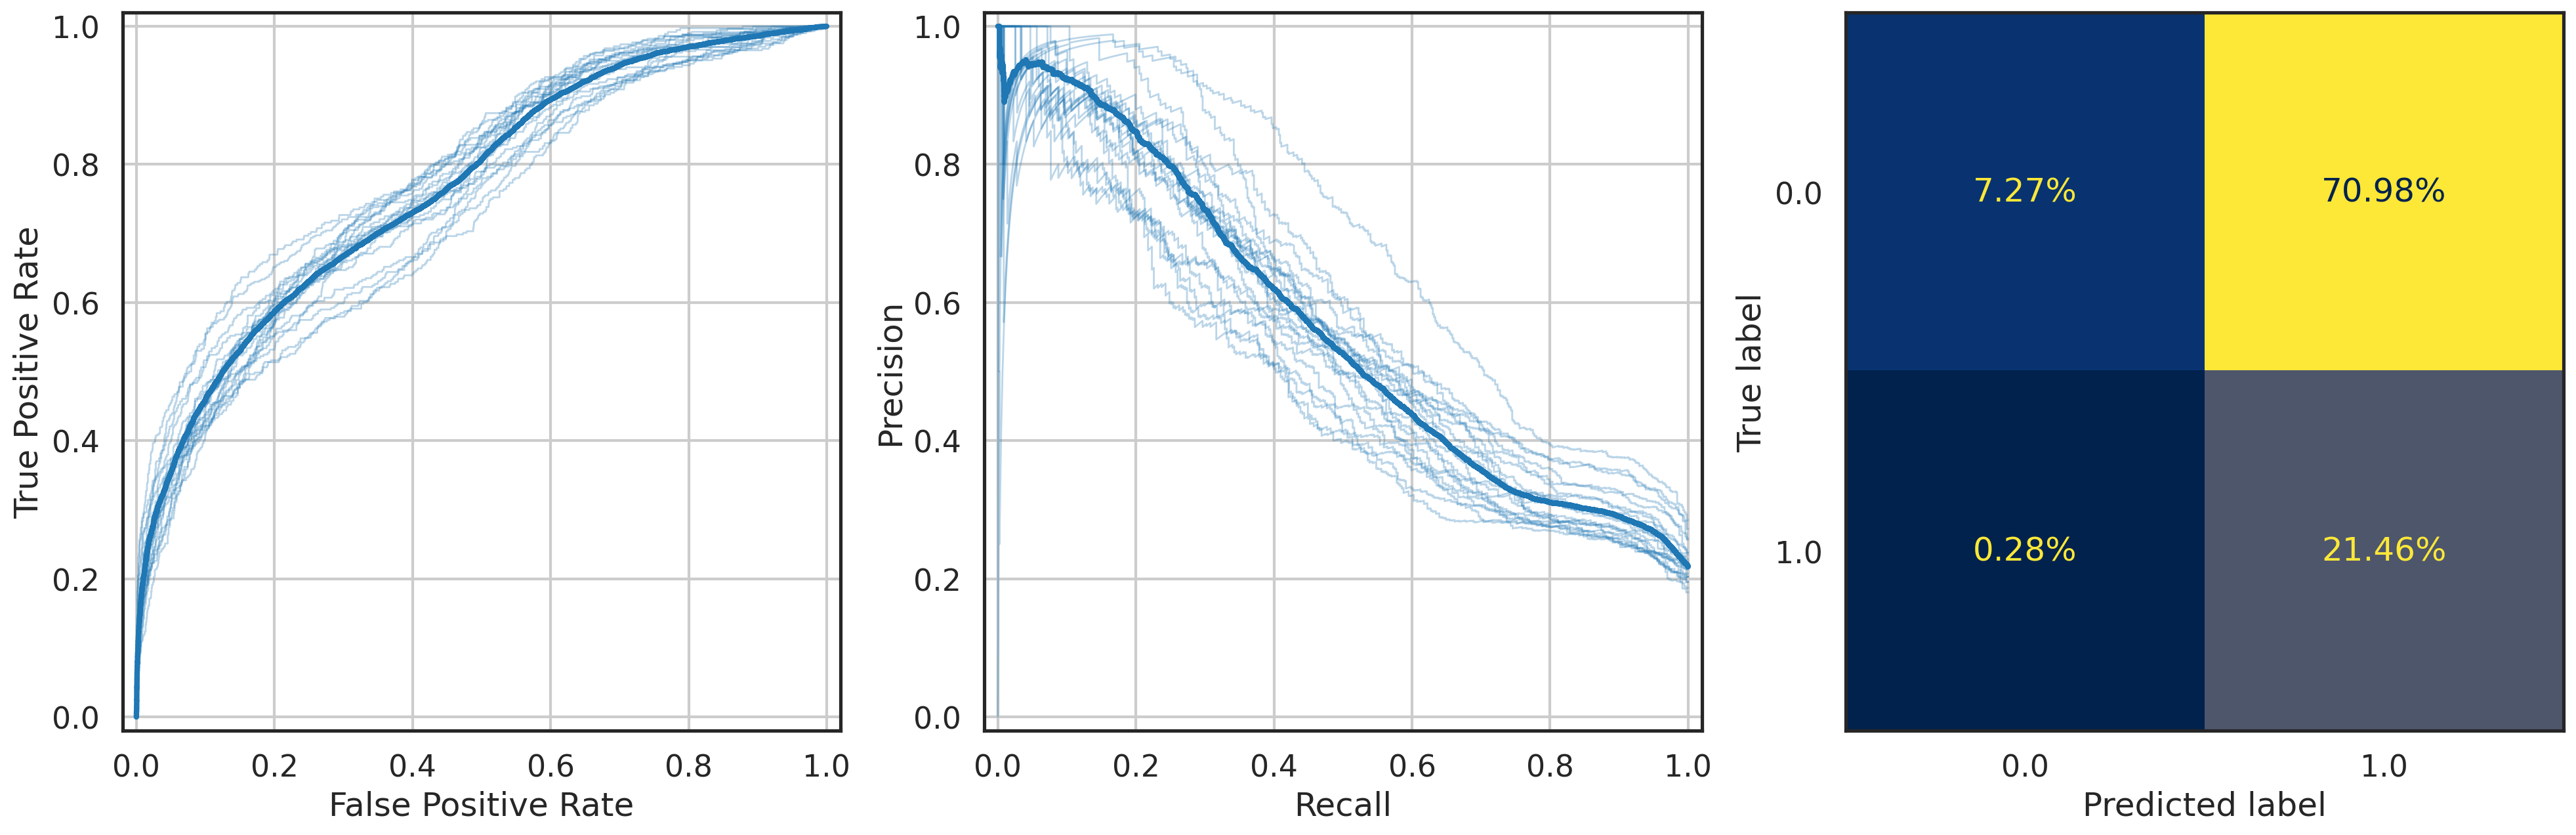

In [12]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))